In [84]:
import (
    "math/rand"
    "bytes"
    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/plotutil"
    "gonum.org/v1/plot/vg"
)

func displayPlot(p *plot.Plot) {
    var buf bytes.Buffer
    c, err := p.WriterTo(6*vg.Inch, 6*vg.Inch, "png")
    if err != nil {
        panic(err)
    }
    if _, err := c.WriteTo(&buf); err != nil {
        panic(err)
    }
    Display(display.PNG(buf.Bytes()))
}

type item struct {
	name  string
	value plot.Thumbnailer
}

func addScatters(plt *plot.Plot, vs ...interface{}) error {
	var ps []plot.Plotter
	var items []item
	name := ""
	var i int
	for _, v := range vs {
		switch t := v.(type) {
		case string:
			name = t

		case plotter.XYer:
			s, err := plotter.NewScatter(t)
			if err != nil {
				return err
			}
			s.Color = plotutil.Color(i)
			s.Shape = draw.CircleGlyph{}
			i++
			ps = append(ps, s)
			if name != "" {
				items = append(items, item{name: name, value: s})
				name = ""
			}

		default:
			panic(fmt.Sprintf("plotutil: AddScatters handles strings and plotter.XYers, got %T", t))
		}
	}
	plt.Add(ps...)
	for _, v := range items {
		plt.Legend.Add(v.name, v.value)
	}
	return nil
}


ERROR: repl.go:43:14: undefined "draw" in draw.CircleGlyph <*ast.SelectorExpr>

In [23]:
import (
	"time"
	"math"
	"fmt"
)

type ConstantPacer struct {
	Freq int
	Per time.Duration
}

func (cp ConstantPacer) Pace(elapsed time.Duration, hits uint64) (time.Duration, bool) {
	switch {
	case cp.Per == 0 || cp.Freq == 0:
		return 0, false // Zero value = infinite rate
	case cp.Per < 0 || cp.Freq < 0:
		return 0, true
	}

	expectedHits := uint64(cp.Freq) * uint64(elapsed/cp.Per)
	if hits < expectedHits {
		// Running behind, send next hit immediately.
		return 0, false
	}
	interval := uint64(cp.Per.Nanoseconds() / int64(cp.Freq))
	if math.MaxInt64/interval < hits {
		// We would overflow delta if we continued, so stop the attack.
		return 0, true
	}
	delta := time.Duration((hits + 1) * interval)
	// Zero or negative durations cause time.Sleep to return immediately.
	return delta - elapsed, false
}

func (cp ConstantPacer) hitsPerNs() float64 {
	return float64(cp.Freq) / float64(cp.Per)
}

func (cp ConstantPacer) Rate(elapsed time.Duration) float64 {
	return cp.hitsPerNs() * 1e9
}

func (cp ConstantPacer) String() string {
	return fmt.Sprintf("Constant{%d hits/%s}", cp.Freq, cp.Per)
}

Constant{2 hits/1s}
[{0 1.5} {1 1} {2 0.5} {3 0} {4 1} {5 0.5} {6 1.5} {7 0} {8 0} {9 0} {10 0} {11 0} {12 0.5} {13 0} {14 0.5} {15 0} {16 0.5} {17 1} {18 0} {19 0} {20 0} {21 0} {22 1.5} {23 1.5} {24 0.5} {25 1.5} {26 0} {27 0} {28 1.5} {29 1.5}]


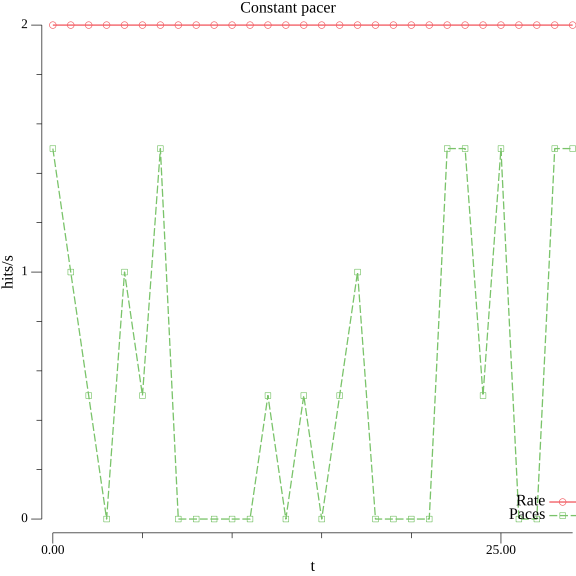

In [67]:
pc := ConstantPacer{
	Freq: 2,
	Per: time.Second,
}

fmt.Printf("%s\n", pc.String())

rates := make(plotter.XYs, 30)
waits := make(plotter.XYs, 30)

for i := range rates {
	t := time.Duration(i) * time.Second
	rates[i].X = float64(t / time.Second)
	rates[i].Y = float64(pc.Rate(t))

	waits[i].X = rates[i].X
	y, _ := pc.Pace(t, uint64(pc.Freq) * uint64(t/pc.Per) + uint64(rand.Int63n(6)-3))
	waits[i].Y = float64(y) / float64(time.Second)
}

fmt.Printf("%v\n", waits)

p := plot.New()
p.Title.Text = "Constant pacer"
p.X.Label.Text = "t"
p.Y.Label.Text = "hits/s"

err := plotutil.AddLinePoints(p, "Rate", rates, "Paces", waits)
displayPlot(p)


In [61]:
type Rate = ConstantPacer

// LinearPacer paces an attack by starting at a given request rate
// and increasing linearly with the given slope.
type LinearPacer struct {
	StartAt Rate
	Slope   float64
}


// hits returns the number of hits that have been sent during an attack
// lasting t nanoseconds. It returns a float so we can tell exactly how
// much we've missed our target by when solving numerically in Pace.
func (p LinearPacer) hits(t time.Duration) float64 {
	if t < 0 {
		return 0
	}

	a := p.Slope
	b := p.StartAt.hitsPerNs() * 1e9
	x := t.Seconds()

	return (a*math.Pow(x, 2))/2 + b*x
}

// Rate returns a LinearPacer's instantaneous hit rate (i.e. requests per second)
// at the given elapsed duration of an attack.
func (p LinearPacer) Rate(elapsed time.Duration) float64 {
	a := p.Slope
	x := elapsed.Seconds()
	b := p.StartAt.hitsPerNs() * 1e9
	return a*x + b
}

// Pace determines the length of time to sleep until the next hit is sent.
func (p LinearPacer) Pace(elapsed time.Duration, hits uint64) (time.Duration, bool) {
	switch {
	case p.StartAt.Per == 0 || p.StartAt.Freq == 0:
		return 0, false // Zero value = infinite rate
	case p.StartAt.Per < 0 || p.StartAt.Freq < 0:
		return 0, true
	}

	expectedHits := p.hits(elapsed)
	if hits == 0 || hits < uint64(expectedHits) {
		// Running behind, send next hit immediately.
		return 0, false
	}

	rate := p.Rate(elapsed)
	interval := math.Round(1e9 / rate)

	if n := uint64(interval); n != 0 && math.MaxInt64/n < hits {
		// We would overflow wait if we continued, so stop the attack.
		return 0, true
	}

	delta := float64(hits+1) - expectedHits
	wait := time.Duration(interval * delta)

	return wait, false
}



In [90]:
// y = a*x + b
// y-b = a*x
// a = (y-b)/x

func slope(durS, target, offset float64) float64 {
	return (target-offset) / durS
}

a := slope(15.0 * 60.0, 900.0, 0.0)
fmt.Printf("slope: %f\n", a)

slope: 1.000000


16 <nil>

[{0 240} {1 120.256115659} {2 116.880978976} {3 35.549399252} {4 72.777448251} {5 0} {6 33.310517493} {7 0} {8 0} {9 0}]


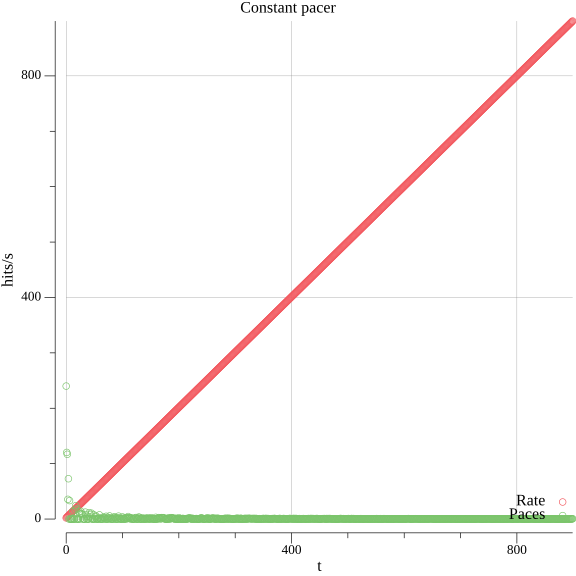

In [97]:
lp := LinearPacer{
	StartAt: pc,
	Slope: slope(15.0 * 60.0, 900.0, 2.0),
}

rates := make(plotter.XYs, 900)
waits := make(plotter.XYs, 900)

for i := range rates {
	t := time.Duration(i) * time.Second
	rates[i].X = float64(t / time.Second)
	rates[i].Y = float64(lp.Rate(t))

	waits[i].X = rates[i].X
	y, _ := lp.Pace(t, uint64(lp.hits(t)) + uint64(rand.Int63n(1000)-500))
	waits[i].Y = float64(y) / float64(time.Second)
}

fmt.Printf("%v\n", waits[:10])

p := plot.New()
p.Add(plotter.NewGrid())
p.Title.Text = "Constant pacer"
p.X.Label.Text = "t"
p.Y.Label.Text = "hits/s"

err := addScatters(p, "Rate", rates, "Paces", waits)
displayPlot(p)
